In [1]:
!pip install scikit-optimize
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

<ipython-input-2-b46d91121558>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Functions

In [5]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [7]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    ddd = pd.DataFrame({'test_lbl': test_label, 'pred_lbl':predicted_dv})
    sns.scatterplot(ddd, x='test_lbl', y='pred_lbl', color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [8]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [9]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [10]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_)
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

### Load df

In [19]:
import pickle

with open('/content/drive/My Drive/Diploma/CODE/Okko_ratings_RUSS.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

In [20]:
with open('/content/drive/My Drive/Diploma/CODE/watches_target_dataset.pkl', 'rb') as f:
    df_target = pickle.load(f, encoding='utf-8')

In [21]:
df_target = df_target[['uid', 'target']]

In [22]:
df_target.rename(columns={'uid': 'element_uid'}, inplace=True)

In [23]:
df_target.shape, df.shape

((11666, 2), (1705, 1027))

In [24]:
df = df.merge(df_target, on='element_uid')

In [25]:
df.shape

(837, 1028)

In [26]:
df.columns[-30:]

Index(['ханна', 'отпор', 'воришка', 'одри', 'деспотичный', 'хэл', 'шоубизнес',
       'провоцировать', 'селин', 'уолтер', 'непобедимый', 'молль', 'небывалый',
       'ларри', 'харпер', 'прихожанин', 'спецподразделение', 'сущий', 'пята',
       'вылечивать', 'землянин', 'рон', 'головоломка', 'крюк', 'чета', 'зебра',
       'сидень', 'беатрис', 'рыбка', 'target'],
      dtype='object')

# Preprocessing

In [41]:
prep_df = df.copy(deep=True)

In [42]:
prep_df.shape

(837, 1028)

In [43]:
prep_df.isna().sum()

age_access_type     0
name                0
director            0
genre               0
average_rating     24
                   ..
зебра               0
сидень              0
беатрис             0
рыбка               0
target              0
Length: 1028, dtype: int64

### filter by year

In [44]:
prep_df = prep_df[prep_df['release_year'] >= 2000]

In [45]:
prep_df.shape

(807, 1028)

In [46]:
prep_df.isna().sum()

age_access_type     0
name                0
director            0
genre               0
average_rating     24
                   ..
зебра               0
сидень              0
беатрис             0
рыбка               0
target              0
Length: 1028, dtype: int64

### topN

In [47]:
# import ast

# columns = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
#                       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
# for col in columns:
#     prep_df[col] = prep_df[col].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else np.nan)

prep_df.dropna(subset=['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER'],
              inplace=True)


In [48]:
prep_df.shape

(411, 1028)

In [49]:
prep_df.isna().sum()

age_access_type    0
name               0
director           0
genre              0
average_rating     7
                  ..
зебра              0
сидень             0
беатрис            0
рыбка              0
target             0
Length: 1028, dtype: int64

In [50]:
def add_topN_feature(df, col, n: int):
    items = []
    
    for i in df[col]:
        items.extend(i)

    topN = [x[0] for x in Counter(items).most_common()][:n]

    df[f'top{n}{col}'] = df[col].apply(lambda x: [int(item in x) for item in topN])
    df.drop(col, axis=1, inplace=True)
    return topN, f'top{n}{col}'

In [51]:
def ohe_topN_features(df, topN, cat):
    for i in range(len(topN)):
        df[f'{topN[i]}'] = [item[i] for item in df[cat]]
    df.drop(cat, axis=1, inplace=True)
    return df

In [52]:
prep_df.columns

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration',
       ...
       'землянин', 'рон', 'головоломка', 'крюк', 'чета', 'зебра', 'сидень',
       'беатрис', 'рыбка', 'target'],
      dtype='object', length=1028)

In [53]:
top10genres, name = add_topN_feature(prep_df, 'genre', 10)
prep_df = ohe_topN_features(prep_df, top10genres, name)

top5countries, name = add_topN_feature(prep_df, 'country', 5)
prep_df = ohe_topN_features(prep_df, top5countries, name)

top10actors, name = add_topN_feature(prep_df, 'ACTOR', 10)
prep_df = ohe_topN_features(prep_df, top10actors, name)

top3directors, name = add_topN_feature(prep_df, 'COMPOSER', 3)
prep_df = ohe_topN_features(prep_df, top3directors, name)

top2DESIGN, name = add_topN_feature(prep_df, 'DESIGN', 2)
prep_df = ohe_topN_features(prep_df, top2DESIGN, name)

top2DIRECTOR, name = add_topN_feature(prep_df, 'DIRECTOR', 2)
prep_df = ohe_topN_features(prep_df, top2DIRECTOR, name)

top2EDITOR, name = add_topN_feature(prep_df, 'EDITOR', 2)
prep_df = ohe_topN_features(prep_df, top2EDITOR, name)

top2OPERATOR, name = add_topN_feature(prep_df, 'OPERATOR', 2)
prep_df = ohe_topN_features(prep_df, top2OPERATOR, name)

top3PRODUCER, name = add_topN_feature(prep_df, 'PRODUCER', 3)
prep_df = ohe_topN_features(prep_df, top3PRODUCER, name)

top2WRITER, name = add_topN_feature(prep_df, 'WRITER', 2)
prep_df = ohe_topN_features(prep_df, top2WRITER, name)

In [54]:
prep_df.head().T

,1,2,4,5,6
age_access_type,16,16,16,18,16
name,Медвежий поцелуй,Байконур,Монгол,Красный змей,Олигарх
director,[3d64928e-b4a3-4c78-b176-77ef1045d5bc],[1f007e2b-31c6-4f3d-849c-95a1df635ab1],[3d64928e-b4a3-4c78-b176-77ef1045d5bc],[622415d8-8c67-495b-acbd-06d04daeec26],[c75aa66a-5ce5-4ec9-85e5-072df00d4ad7]
average_rating,7.43,6.09,6.97,1.37,7.4
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
...,...,...,...,...,...
Сергей Сельянов,1,1,1,0,1
Георгий Малков,0,0,0,0,0
Тимур Бекмамбетов,0,0,0,0,0
Роман Непомнящий,0,0,0,0,0


In [55]:
prep_df.columns

Index(['age_access_type', 'name', 'director', 'average_rating', 'type',
       'release_type', 'release_year', 'duration', 'actor', 'element_uid',
       ...
       'Алексей Балабанов', 'Александр Амиров', 'Сергей Иванов',
       'Сергей Трофимов', 'Максим Осадчий', 'Сергей Сельянов',
       'Георгий Малков', 'Тимур Бекмамбетов', 'Роман Непомнящий',
       'Александр Боярский'],
      dtype='object', length=1059)

In [56]:
prep_df.columns[:30]

Index(['age_access_type', 'name', 'director', 'average_rating', 'type',
       'release_type', 'release_year', 'duration', 'actor', 'element_uid',
       'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD', 'element_id', 'rating',
       'джек', 'расследовать', 'подруга', 'ограбление', 'катя', 'макс',
       'мечтать', 'отважный', 'фрэнк', 'воспитывать', 'супергерой',
       'безжалостный', 'маньяк'],
      dtype='object')

In [57]:
prep_df.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id', 'rating'], axis=1, inplace=True)

In [58]:
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'] 

In [59]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

class Preprocesser:
    def __init__(self, 
#                 mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
#                 mltpl_cat_n_top: dict
                ):
#         self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
#         self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
#         df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [60]:
preprocesser = Preprocesser(
#     mltpl_cat_features,
            skewed_num_features,
            #text_features,
#             mltpl_cat_n_top
                           )

In [61]:
df_pr = preprocesser.preprocess(prep_df)

In [62]:
df_pr.isnull().sum()

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
                     ..
Сергей Сельянов       0
Георгий Малков        0
Тимур Бекмамбетов     0
Роман Непомнящий      0
Александр Боярский    0
Length: 1053, dtype: int64

### target destr

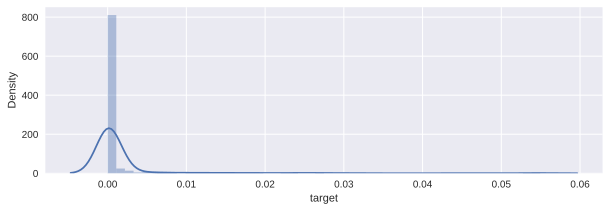

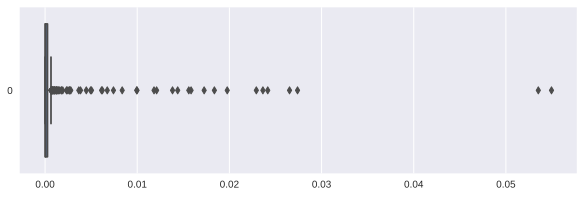

In [63]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['target'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['target'].values, orient='h')
plt.show()

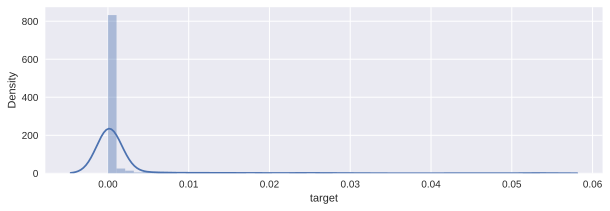

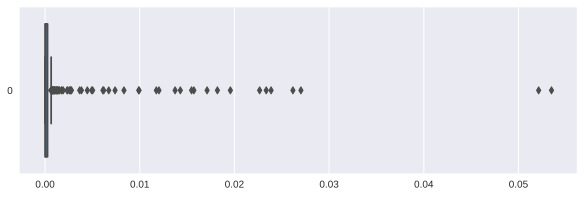

In [64]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['target'].apply(lambda x: np.log1p(x)))
plt.show()

plt.figure(figsize=(10, 3))
x=df_pr['target'].apply(lambda x: np.log1p(x))
sns.boxplot(x.values, orient='h')
plt.show()

## Split

In [65]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'Алексей Балабанов', 'Александр Амиров', 'Сергей Иванов',
       'Сергей Трофимов', 'Максим Осадчий', 'Сергей Сельянов',
       'Георгий Малков', 'Тимур Бекмамбетов', 'Роман Непомнящий',
       'Александр Боярский'],
      dtype='object', length=1053)

In [66]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)


X_test, y_test = test.drop('target', axis=1), test['target']
y_test = y_test.apply(lambda x: np.log1p(x))

X, y = train.drop('target', axis=1), train['target']
y = y.apply(lambda x: np.log1p(x))
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((363, 1049), (41, 1049), (7, 1049), (363,), (41,), (7,))

In [67]:
X_train.columns

Index(['age_access_type', 'type', 'duration', 'BUDGET', 'MARKETING', 'RUS',
       'USA', 'WORLD', 'джек', 'расследовать',
       ...
       'Алексей Балабанов', 'Александр Амиров', 'Сергей Иванов',
       'Сергей Трофимов', 'Максим Осадчий', 'Сергей Сельянов',
       'Георгий Малков', 'Тимур Бекмамбетов', 'Роман Непомнящий',
       'Александр Боярский'],
      dtype='object', length=1049)

In [69]:
cat_features = ['age_access_type', 'type']

In [70]:
# sc
from sklearn.preprocessing import StandardScaler

sc_cols = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA']

sc=StandardScaler()
sc_train = sc.fit_transform(X_train[sc_cols])

sc_train = pd.DataFrame(sc_train, index=X_train.index, columns=sc_cols)
X_train.drop(sc_cols, axis=1, inplace=True)
print(X_train.shape)
X_train = pd.concat([X_train, sc_train],axis=1)
print(X_train.shape)

# 
sc_val = sc.transform(X_val[sc_cols])
sc_val = pd.DataFrame(sc_val, index=X_val.index, columns=sc_cols)
X_val.drop(sc_cols, axis=1, inplace=True)
print(X_val.shape)
X_val = pd.concat([X_val, sc_val],axis=1) 
print(X_val.shape)

# 
sc_test = sc.transform(X_test[sc_cols])
sc_test = pd.DataFrame(sc_test, index=X_test.index, columns=sc_cols)
X_test.drop(sc_cols, axis=1, inplace=True)
print(X_test.shape)
X_test = pd.concat([X_test, sc_test],axis=1) 
print(X_test.shape)

(363, 1044)
(363, 1049)
(41, 1044)
(41, 1049)
(7, 1044)
(7, 1049)


# Modeling

In [71]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.2 MB/s eta 0:00:00


In [72]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [73]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.043431
0:	learn: 0.0004689	test: 0.0075604	best: 0.0075604 (0)	total: 63.4ms	remaining: 1m 3s
100:	learn: 0.0003191	test: 0.0073526	best: 0.0073526 (100)	total: 1.37s	remaining: 12.2s
200:	learn: 0.0002379	test: 0.0072941	best: 0.0072941 (200)	total: 2.02s	remaining: 8.01s
300:	learn: 0.0001819	test: 0.0072815	best: 0.0072815 (299)	total: 3.08s	remaining: 7.16s
400:	learn: 0.0001469	test: 0.0072779	best: 0.0072775 (394)	total: 4.05s	remaining: 6.05s
500:	learn: 0.0001228	test: 0.0072777	best: 0.0072774 (494)	total: 4.88s	remaining: 4.86s
600:	learn: 0.0001052	test: 0.0072773	best: 0.0072765 (529)	total: 5.75s	remaining: 3.82s
700:	learn: 0.0000912	test: 0.0072786	best: 0.0072765 (529)	total: 6.13s	remaining: 2.62s
800:	learn: 0.0000806	test: 0.0072794	best: 0.0072765 (529)	total: 6.51s	remaining: 1.62s
900:	learn: 0.0000713	test: 0.0072809	best: 0.0072765 (529)	total: 7.19s	remaining: 790ms
999:	learn: 0.0000632	test: 0.0072819	best: 0.0072765 (529)	total: 7.95s	

In [74]:
y_pred = cat_model.predict(test_dataset)

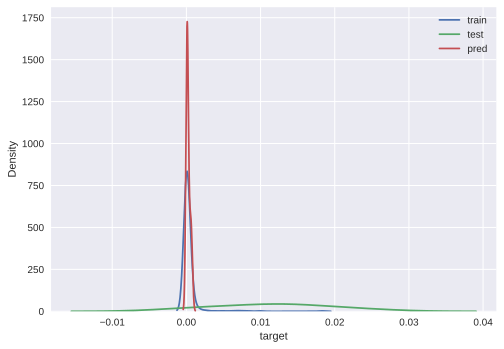

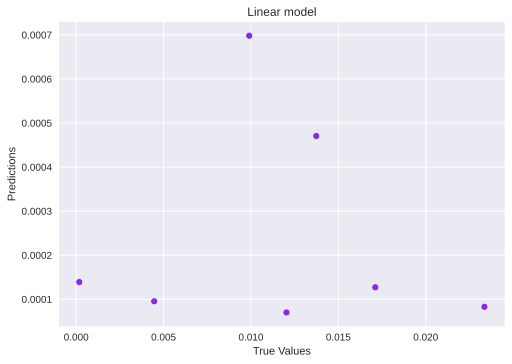

In [75]:
target_distr_linear(y_train, y_test, y_pred)   

In [76]:
def inverse_transform(feature):
    return np.expm1(feature)

calc_metrics(inverse_transform(y_test), inverse_transform(y_pred))

*** VAL **: 
MSE:   0.00018234895023751287
RMSE:  0.013503664326304652
R2:    -2.4867152434781814
MAE:   0.0113932911298217
MedAE: 0.012033855572419516
------------------------------


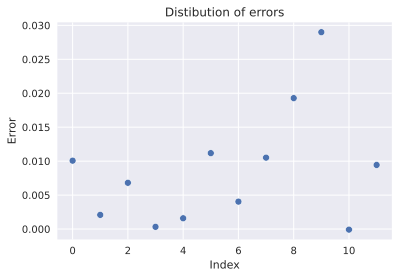

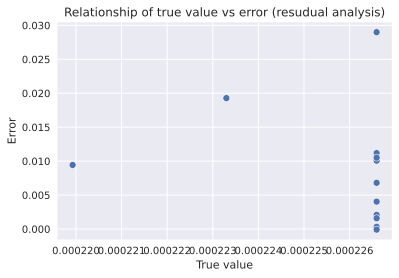

In [ ]:
# errors = y_test - y_pred
# draw_res_analys(errors, y_pred)

**Conclusion**
* The trend in the second figure is not visible, now we will confirm the presence of heteroskedasticity on tests.

In [77]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)
    imp_features_df = pd.DataFrame({"score":imp, "feat": model.feature_names_})
    imp_features_df = imp_features_df.sort_values(by='score')[-20:]

    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp_features_df['score'].values, y=imp_features_df["feat"].values)
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

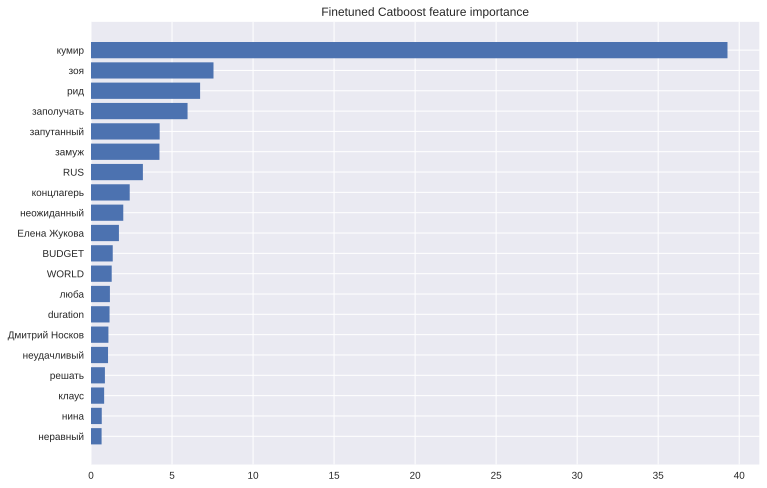

In [78]:
get_feature_imp(cat_model, train_dataset)

In [79]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

,age_access_type,name,type,release_year,duration,element_uid,BUDGET,MARKETING,RUS,USA,...,Сергей Иванов,Сергей Трофимов,Максим Осадчий,Сергей Сельянов,Георгий Малков,Тимур Бекмамбетов,Роман Непомнящий,Александр Боярский,PREDS,TARGET
710,18,Ника,MOVIE,2022,15.566448,5bd9b8c0-b482-4953-951a-813985e55e2d,NaN,NaN,12.233522,NaN,...,0,0,0,0,0,0,0,0,0.000095,0.004464
396,18,Приплыли!,MOVIE,2022,15.479437,02eaefe0-296d-4e6f-b52f-2e2507d07103,NaN,NaN,12.593543,NaN,...,0,0,0,0,0,0,0,0,0.000698,0.009902
158,16,Многоэтажка,MOVIE,2022,15.597220,19a61cc3-65ff-46ce-bf43-29c24a1cc9b6,NaN,NaN,5.793014,NaN,...,0,0,0,0,0,0,0,0,0.000127,0.017114
747,12,Тайна амулета,MOVIE,2022,15.545395,9ae35927-93e3-4a40-870f-a998abbeaa9f,NaN,NaN,12.057422,NaN,...,0,0,0,0,0,0,0,0,0.000139,0.000178
203,16,День слепого Валентина,MOVIE,2022,15.711630,6b047b99-5cb4-4878-9a4f-b8b372b438eb,NaN,NaN,12.935033,NaN,...,0,0,0,0,0,0,0,0,0.000083,0.023361
332,16,Доктор Свисток,MOVIE,2022,15.332833,967bf940-27b7-4d93-95ad-43c7459077e7,NaN,NaN,12.638501,NaN,...,0,0,0,0,1,0,0,0,0.000070,0.012031
711,12,Первый Оскар,MOVIE,2022,15.738298,e69d2f4d-bb65-4e7e-93e1-74da99424ae8,NaN,NaN,14.252288,NaN,...,0,0,0,0,0,0,0,0,0.000470,0.013736


In [ ]:
# predict demo dataset

# Tuning

In [80]:
train_dataset = cat.Pool(X_train, y_train, 
                         cat_features=cat_features) 

test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [81]:
parameters_distr = {'depth': randint(5, 10),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [5000, 10000, 15000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5, 
                          n_jobs=-1,
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_okko_rat_ntop_scrs_kws_views_russ', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.0004692	total: 20.6ms	remaining: 1m 43s
1:	learn: 0.0004675	total: 23ms	remaining: 57.4s
2:	learn: 0.0004639	total: 40.7ms	remaining: 1m 7s
3:	learn: 0.0004619	total: 57.1ms	remaining: 1m 11s
4:	learn: 0.0004591	total: 74.1ms	remaining: 1m 13s
5:	learn: 0.0004564	total: 90.6ms	remaining: 1m 15s
6:	learn: 0.0004541	total: 107ms	remaining: 1m 16s
7:	learn: 0.0004526	total: 124ms	remaining: 1m 17s
8:	learn: 0.0004489	total: 141ms	remaining: 1m 18s
9:	learn: 0.0004466	total: 157ms	remaining: 1m 18s
10:	learn: 0.0004442	total: 174ms	remaining: 1m 18s
11:	learn: 0.0004413	total: 190ms	remaining: 1m 18s
12:	learn: 0.0004399	total: 206ms	remaining: 1m 19s
13:	learn: 0.0004377	total: 229ms	remaining: 1m 21s
14:	learn: 0.0004343	total: 247ms	remaining: 1m 22s
15:	learn: 0.0004313	total: 264ms	remaining: 1m 22s
16:	learn: 0.0004293	total: 281ms	remaining: 1m 22s
17:	learn: 0.0004276	total: 298ms	remaining: 1m 22s
18:	

{'depth': 9, 'iterations': 5000, 'learning_rate': 0.04013590769201548}

In [82]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 9, 'iterations': 5000, 'learning_rate': 0.04013590769201548}

In [83]:
grid.best_score_

-3.754187690316621

In [84]:
best_cat.save_model('parsed_ratings_okko_tune_ntop_scrs_kws_views_russ')

In [85]:
y_pred = best_cat.predict(test_dataset)

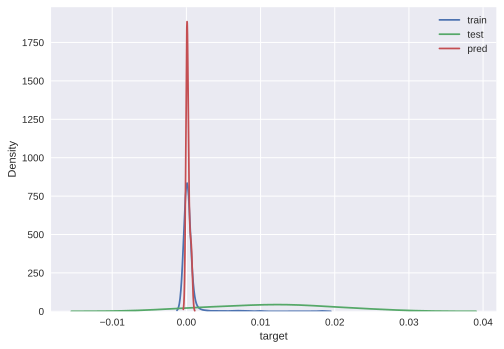

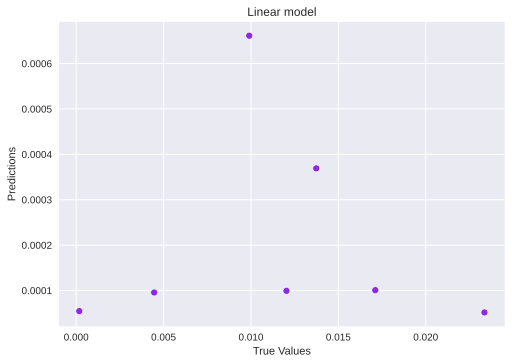

In [86]:
target_distr_linear(y_train, y_test, y_pred)  

In [87]:
calc_metrics(inverse_transform(y_test), inverse_transform(y_pred))

*** VAL **: 
MSE:   0.0001830759753263503
RMSE:  0.013530557095934754
R2:    -2.5006167737932112
MAE:   0.011429115607869423
MedAE: 0.012004590582296954
------------------------------


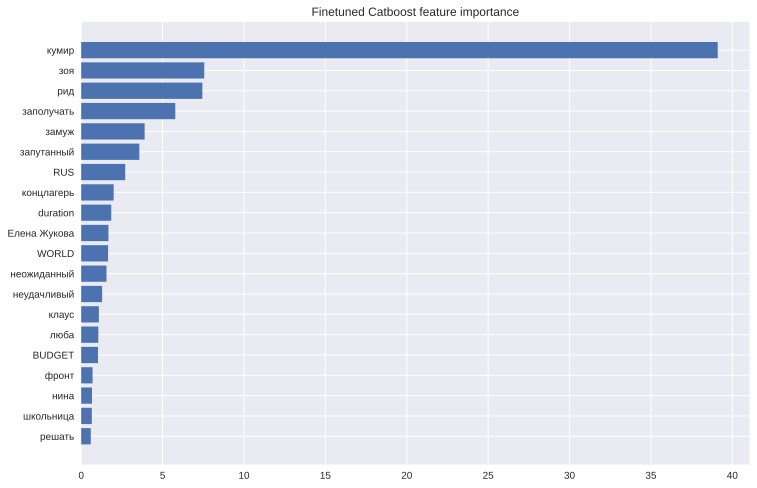

In [88]:
get_feature_imp(best_cat, train_dataset)

In [89]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

,age_access_type,name,type,release_year,duration,element_uid,BUDGET,MARKETING,RUS,USA,...,Сергей Трофимов,Максим Осадчий,Сергей Сельянов,Георгий Малков,Тимур Бекмамбетов,Роман Непомнящий,Александр Боярский,PREDS,TARGET,PREDS_tune
710,18,Ника,MOVIE,2022,15.566448,5bd9b8c0-b482-4953-951a-813985e55e2d,NaN,NaN,12.233522,NaN,...,0,0,0,0,0,0,0,0.000095,0.004464,0.000096
396,18,Приплыли!,MOVIE,2022,15.479437,02eaefe0-296d-4e6f-b52f-2e2507d07103,NaN,NaN,12.593543,NaN,...,0,0,0,0,0,0,0,0.000698,0.009902,0.000661
158,16,Многоэтажка,MOVIE,2022,15.597220,19a61cc3-65ff-46ce-bf43-29c24a1cc9b6,NaN,NaN,5.793014,NaN,...,0,0,0,0,0,0,0,0.000127,0.017114,0.000101
747,12,Тайна амулета,MOVIE,2022,15.545395,9ae35927-93e3-4a40-870f-a998abbeaa9f,NaN,NaN,12.057422,NaN,...,0,0,0,0,0,0,0,0.000139,0.000178,0.000054
203,16,День слепого Валентина,MOVIE,2022,15.711630,6b047b99-5cb4-4878-9a4f-b8b372b438eb,NaN,NaN,12.935033,NaN,...,0,0,0,0,0,0,0,0.000083,0.023361,0.000052
332,16,Доктор Свисток,MOVIE,2022,15.332833,967bf940-27b7-4d93-95ad-43c7459077e7,NaN,NaN,12.638501,NaN,...,0,0,0,1,0,0,0,0.000070,0.012031,0.000099
711,12,Первый Оскар,MOVIE,2022,15.738298,e69d2f4d-bb65-4e7e-93e1-74da99424ae8,NaN,NaN,14.252288,NaN,...,0,0,0,0,0,0,0,0.000470,0.013736,0.000369
